# 抽出された特徴量の評価

In [265]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import sklearn.preprocessing
%matplotlib inline


In [279]:
import glob

onomatpeia_list = [
    'clutter', 'gochagocha',
    'murmur', 'sarasara',
    'twinkle', 'kirakira',
]

dat = json.load(open("figure_features.json"))
dirname_list = []

for onomatpeia in onomatpeia_list:
    dirname_pattern = 'jsons/%s/*' % onomatpeia
    for dirname in sorted(glob.glob(dirname_pattern)):
        dirname_list.append(dirname)


In [282]:
for d, dirname in zip(dat, dirname_list):
    d = np.array(d)
    print dirname, "\t", d.mean(0)

jsons/clutter/JPN 	[  9.18008205e-04   1.40908501e-03   3.63532737e-03   3.85711382e-03
   7.19528608e-03   6.60356291e-03   1.30088849e-02   5.35895178e-02
   3.97903686e-01   4.36896387e-01   4.49459519e-02   1.21431088e-02
   8.02554142e-03   3.72029064e-03   2.84782124e-03   1.12835059e-03
   1.01998963e-03   1.15208707e-03   2.43549020e+02]
jsons/clutter/WRD 	[  8.01867406e-04   1.46705592e-03   2.43909420e-03   3.62032424e-03
   4.04810599e-03   7.28805783e-03   1.15217413e-02   6.02121161e-02
   3.82622831e-01   4.57898078e-01   4.75371298e-02   1.03544297e-02
   4.23022668e-03   1.69542264e-03   1.92109093e-03   1.13620479e-03
   4.18839022e-04   7.87384571e-04   2.22346154e+02]
jsons/gochagocha/JPN 	[  4.44395261e-04   7.85242979e-04   2.07894190e-03   4.35106372e-03
   6.39393004e-03   1.27374051e-02   2.94176848e-02   9.14222971e-02
   3.61410420e-01   3.63064130e-01   7.32260393e-02   2.92086974e-02
   1.24687850e-02   5.84059663e-03   3.78865139e-03   1.56888789e-03
   1.0

In [283]:
feat = np.array([np.array(d).mean(0) for d in dat])

In [361]:
def gen_angle(idx):
    bin_range = 2 * np.pi / 18
    return np.random.random() * bin_range + bin_range * idx - np.pi


def randomwalk(feat, length):
    angle = []
    for i in range(length):
        idx = np.argmax(np.random.multinomial(1, feat))
        angle.append( gen_angle(idx) )
    angle = np.array(angle)
    
    point = np.zeros(2)
    path = [point.copy()]
    edge_len = 10
    direction = 0
    
    for a in angle:
        dp = np.array([np.cos(direction), np.sin(direction)]) * edge_len
        point += dp
        path.append(point.copy())
        direction += a

    path = np.vstack(path)
    
    return path

def plot_path(path, marker=None):
    size = max(path.max(1) - path.min(1))
    plt.subplot(111).set_aspect(1)

    plt.plot(*path.T, marker=marker)    


In [300]:
for f, d in zip(feat, dirname):
    path = randomwalk(f)
    
    plot_path(path)
    
    plt.savefig("random_walk_images/%s.png" % d.replace('/', '_'))
    plt.clf()


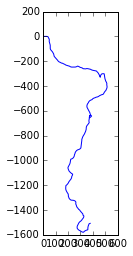

In [302]:
path = randomwalk(feat[0])
plot_path(path)

In [303]:
norm = lambda x: sklearn.preprocessing.normalize(x, norm='l1')[0]

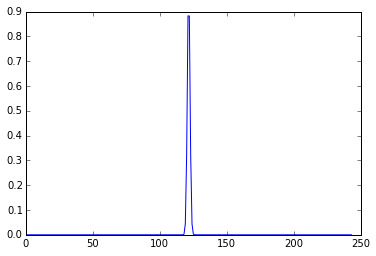

In [304]:
plt.plot( scipy.signal.gaussian(len(path), 1), marker=None )

In [305]:
def gen_bone(path, sigma):
    window_ = scipy.signal.gaussian(len(path) * 2, sigma)
    def window(x):
        l = len(window_)/2
        return norm(window_[l-x:2*l-x])[:, None]
    bone = np.array([(path * window(i)).sum(0) for i in range(len(path))])
    return bone

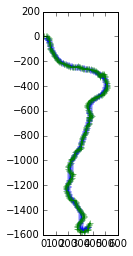

In [306]:
plot_path(gen_bone(path, 5), marker='+')
plot_path(path, marker='+')

In [307]:
def rotate(vec2, theta):
    mat = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]])
    return vec2.dot(mat)
    

In [308]:
def gen_circle(n, radius):
    xs = []
    for i in range(n):
        a = i * np.pi * 2 / n
        xs.append([np.cos(a), np.sin(a)])
    return np.array(xs) * radius

In [344]:
def to_circle(path, sigma):
    bone = gen_bone(path, sigma)
    bone_edge = bone[1:] - bone[:-1]
    
    meat = []

    for i in range(len(path)-1):
        p = path[i] - bone[i]
        e = bone_edge[i]
        arg = np.arctan2(p[1], p[0]) - np.arctan2(e[1], e[0])
        scale = np.linalg.norm(p) / np.linalg.norm(e)
        meat.append([arg, scale])
    
    circle = gen_circle(len(path), 200)
    circle_edge = circle[1:] - circle[:-1]
    
    circle_path = []
    for i in range(len(path)-1):
        arg, scale = meat[i]
        e = circle_edge[i]
        c = circle[i]
        p = c + rotate(e, arg) * scale
        circle_path.append(p)

    circle_path = np.array(circle_path)
    return circle_path


def gen_avarage_shape(feat, sigma=5):
    length = int(feat[-1])
    feat = feat[:-1]
    sigma = length / 10

    path = randomwalk(feat, length)
    return to_circle(path, sigma)


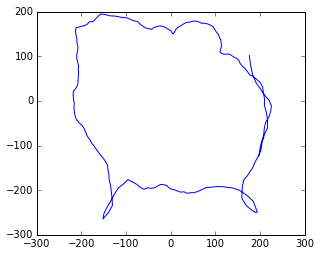

In [345]:
plot_path(to_circle(path, 10))

In [346]:
path = randomwalk(feat[5])
plot_path(to_circle(path, 0.1))

IndexError: invalid index to scalar variable.

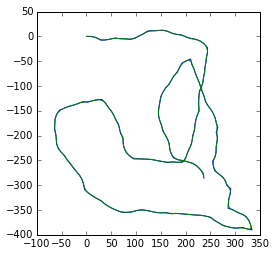

In [347]:
plot_path(path)
plot_path(gen_bone(path, 0.1))

# 平均図形の生成

In [348]:
sigma = 10

jsons/clutter/JPN


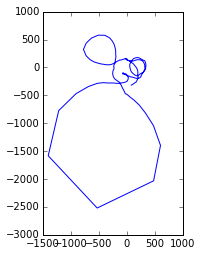

In [375]:
num = 0
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)
plot_path(gen_avarage_shape(feat, sigma))

jsons/clutter/WRD


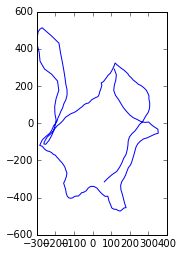

In [376]:
num = 1
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)
plot_path(gen_avarage_shape(feat, sigma))

jsons/gochagocha/JPN


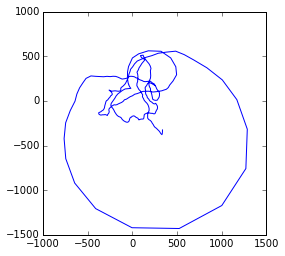

In [377]:
num = 2
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)
plot_path(gen_avarage_shape(feat,  sigma))

jsons/gochagocha/WRD


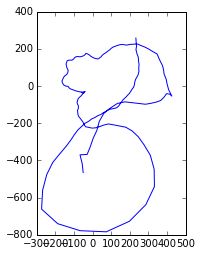

In [378]:
num = 3
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)
plot_path(gen_avarage_shape(feat,  sigma))

jsons/murmur/JPN


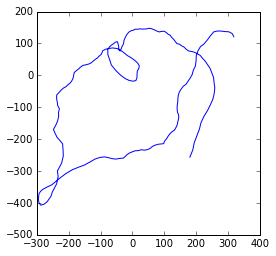

In [379]:
num = 4
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)
plot_path(gen_avarage_shape(feat, sigma))

jsons/murmur/WRD


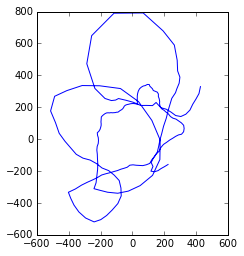

In [380]:
num = 5
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)
plot_path(gen_avarage_shape(feat, sigma))

jsons/sarasara/JPN


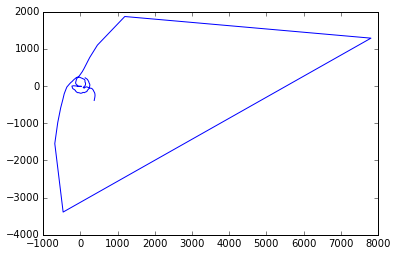

In [381]:
num = 6
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)
plot_path(gen_avarage_shape(feat, sigma))

jsons/sarasara/WRD


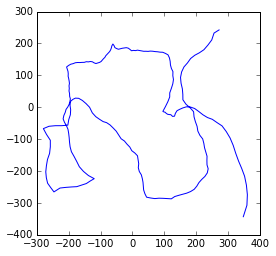

In [382]:
num = 7
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)
plot_path(gen_avarage_shape(feat, sigma))

jsons/twinkle/JPN


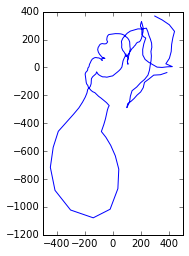

In [383]:
num = 8
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)
plot_path(gen_avarage_shape(feat, sigma))

jsons/twinkle/WRD


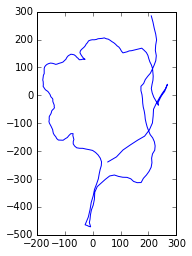

In [384]:
num = 9
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)
plot_path(gen_avarage_shape(feat, sigma))

jsons/kirakira/JPN


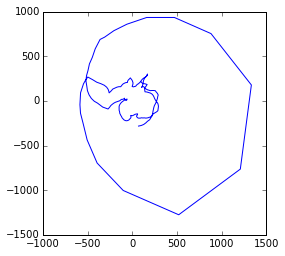

In [385]:
num = 10
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)
plot_path(gen_avarage_shape(feat, sigma))

jsons/kirakira/WRD


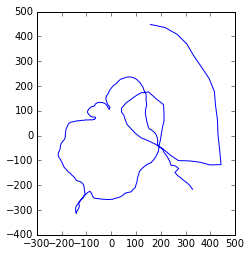

In [386]:
num = 11
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)
plot_path(gen_avarage_shape(feat, sigma))

In [387]:
for num in range(len(dirname_list)):
    dirname = dirname_list[num]
    feat = np.mean(dat[num], axis=0)
    plot_path(gen_avarage_shape(feat, sigma))
    plt.savefig('avarage_images/%s.png' % dirname.replace('/', '_'))
    plt.clf()